# Project 101 — Error Analysis & Model Reflection

## Purpose
This notebook performs qualitative error analysis on the baseline model by:
- Identifying misclassified test samples
- Explaining misclassifications using SHAP outputs
- Distinguishing between reasonable errors (uncertainty-driven) and concerning errors (structural weaknesses)

This stage prioritizes model understanding over immediate performance optimization.

In [1]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

shap.initjs()

In [2]:
DATA_PATH = "../data/processed/stock_features_v1.csv"
MODEL_PATH = "../models/rf_baseline_v1.pkl"

df = pd.read_csv(DATA_PATH)
rf = joblib.load(MODEL_PATH)

df.shape, type(rf)

((4981, 18), sklearn.ensemble._forest.RandomForestClassifier)

In [3]:
# Target
y = df["target"].copy()

# Features: use the exact feature set seen during training
X = df[rf.feature_names_in_].copy()

X.shape, y.shape

((4981, 16), (4981,))

In [4]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

X_test = X.iloc[split_index:].reset_index(drop=True)
y_test = y.iloc[split_index:].reset_index(drop=True)

X_test.shape, y_test.shape

((997, 16), (997,))

In [5]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)

len(y_pred), y_proba.shape

(997, (997, 2))

## Sanity Check
We ensure that the test feature matrix matches exactly what the model expects.
This prevents feature mismatch issues (e.g., accidentally including non-feature columns).

In [6]:
extra_cols = set(X_test.columns) - set(rf.feature_names_in_)
missing_cols = set(rf.feature_names_in_) - set(X_test.columns)

extra_cols, missing_cols

(set(), set())

In [7]:
error_df = X_test.copy()

# Attach ground truth and predictions
error_df["y_true"] = y_test.values
error_df["y_pred"] = y_pred

# Attach predicted probabilities if available
if "y_proba" in globals() and y_proba is not None:
    # Binary classification: take probability of the positive class (column 1)
    if hasattr(y_proba, "ndim") and y_proba.ndim == 2 and y_proba.shape[1] >= 2:
        error_df["y_proba_pos"] = y_proba[:, 1]
    else:
        # If already 1D, treat it as positive-class probability
        error_df["y_proba_pos"] = np.asarray(y_proba).ravel()

# Flag misclassified samples
error_df["is_misclassified"] = error_df["y_true"] != error_df["y_pred"]

error_df.head()

,Price,Open,High,Low,Vol.,Change %,return_1d,return_lag_1,return_lag_3,return_lag_5,ma_5,ma_10,ma_20,volatility_5,volatility_10,volume_change,y_true,y_pred,y_proba_pos,is_misclassified
0,28.95,29.05,29.45,28.84,11320000.0,-0.07,-0.000690,0.001037,-0.009990,-0.007573,28.926,29.173,29.8460,0.006969,0.009045,0.657394,0,0,0.414848,False
1,28.79,28.64,28.95,28.44,7490000.0,-0.55,-0.005527,-0.000690,0.006959,0.006937,28.878,29.059,29.7275,0.006458,0.007406,-0.338339,0,0,0.393770,False
2,27.09,27.42,28.13,27.02,15470000.0,-5.90,-0.059048,-0.005527,0.001037,-0.009990,28.548,28.792,29.5235,0.026978,0.019010,1.065421,1,0,0.451202,True
3,27.67,27.22,27.83,27.22,5730000.0,2.14,0.021410,-0.059048,-0.000690,0.006959,28.294,28.606,29.3585,0.030044,0.021348,-0.629606,0,0,0.462567,False
4,27.40,27.62,27.62,27.02,7430000.0,-0.98,-0.009758,0.021410,-0.005527,0.001037,27.980,28.441,29.1880,0.029565,0.021108,0.296684,0,0,0.439306,False


In [8]:
n_total = len(error_df)
n_errors = int(error_df["is_misclassified"].sum())
error_rate = n_errors / n_total if n_total else 0.0

print(f"Total test samples: {n_total}")
print(f"Misclassified samples: {n_errors}")
print(f"Error rate: {error_rate:.2%}")

Total test samples: 997
Misclassified samples: 507
Error rate: 50.85%


In [9]:
misclassified_df = error_df[error_df["is_misclassified"]].copy()
misclassified_df.head()

,Price,Open,High,Low,Vol.,Change %,return_1d,return_lag_1,return_lag_3,return_lag_5,ma_5,ma_10,ma_20,volatility_5,volatility_10,volume_change,y_true,y_pred,y_proba_pos,is_misclassified
2,27.09,27.42,28.13,27.02,15470000.0,-5.90,-0.059048,-0.005527,0.001037,-0.009990,28.548,28.792,29.5235,0.026978,0.019010,1.065421,1,0,0.451202,True
7,25.89,26.51,26.71,25.70,14380000.0,0.94,0.009357,-0.045048,-0.009758,-0.059048,26.694,27.621,28.5215,0.025866,0.024957,-0.068653,1,0,0.407294,True
8,26.08,25.90,26.20,25.80,10290000.0,0.73,0.007339,0.009357,-0.019708,0.021410,26.376,27.335,28.3170,0.022281,0.024986,-0.284423,1,0,0.444697,True
9,26.62,26.10,26.81,26.10,12590000.0,2.07,0.020706,0.007339,-0.045048,-0.009758,26.220,27.100,28.1665,0.026637,0.026674,0.223518,1,0,0.407012,True
11,26.78,26.81,26.81,26.41,7970000.0,-0.63,-0.006308,0.012397,0.007339,-0.045048,26.464,26.699,27.8790,0.009815,0.027387,-0.316467,1,0,0.437509,True


In [10]:
# Identify false positives and false negatives (assumes binary labels 0/1)
misclassified_df["error_type"] = np.where(
    (misclassified_df["y_true"] == 0) & (misclassified_df["y_pred"] == 1),
    "False Positive",
    np.where(
        (misclassified_df["y_true"] == 1) & (misclassified_df["y_pred"] == 0),
        "False Negative",
        "Other"
    )
)

misclassified_df["error_type"].value_counts(dropna=False)

error_type
False Negative    492
False Positive     15
Name: count, dtype: int64

In [11]:
if "y_proba_pos" in misclassified_df.columns:
    # Confidence as distance from the decision boundary (0.5)
    misclassified_df["pred_confidence"] = np.abs(misclassified_df["y_proba_pos"] - 0.5)

    top_confident_errors = misclassified_df.sort_values(
        by="pred_confidence",
        ascending=False
    ).head(15)

    top_confident_errors[["y_true", "y_pred", "y_proba_pos", "pred_confidence", "error_type"]].head(15)
else:
    print("No probability column found (y_proba_pos). Skipping confidence-based error analysis.")

In [12]:
# Heuristically detect time-related engineered features
time_cols = [
    c for c in error_df.columns
    if any(k in c.lower() for k in ["date", "day", "month", "year", "week", "dow", "weekday"])
]

time_cols

[]

In [13]:
candidate_time_features = ["day_of_week", "weekday", "dow", "month", "week_of_year"]

time_feature = next((c for c in candidate_time_features if c in error_df.columns), None)

if time_feature is not None:
    error_rate_by_time = error_df.groupby(time_feature)["is_misclassified"].mean().sort_index()
    error_rate_by_time
else:
    print("No common time feature found in columns. You can set `time_feature` manually.")

No common time feature found in columns. You can set `time_feature` manually.


In [14]:
output_path = "../data/processed/misclassified_samples.csv"
misclassified_df.to_csv(output_path, index=False)

print(f"Saved misclassified samples to: {output_path}")

Saved misclassified samples to: ../data/processed/misclassified_samples.csv


In [15]:
correct_df = error_df[~error_df["is_misclassified"]].copy()
incorrect_df = error_df[error_df["is_misclassified"]].copy()

print(f"Correct predictions:   {correct_df.shape[0]}")
print(f"Incorrect predictions: {incorrect_df.shape[0]}")

Correct predictions:   490
Incorrect predictions: 507


In [16]:
non_feature_cols = {"y_true", "y_pred", "is_misclassified", "y_proba_pos", "pred_confidence", "error_type"}
feature_cols = [c for c in error_df.columns if c not in non_feature_cols]

print(f"Number of feature columns: {len(feature_cols)}")
feature_cols[:20]

Number of feature columns: 16


['Price',
 'Open',
 'High',
 'Low',
 'Vol.',
 'Change %',
 'return_1d',
 'return_lag_1',
 'return_lag_3',
 'return_lag_5',
 'ma_5',
 'ma_10',
 'ma_20',
 'volatility_5',
 'volatility_10',
 'volume_change']

In [17]:
numeric_features = [
    c for c in feature_cols
    if pd.api.types.is_numeric_dtype(error_df[c])
]

shift_rows = []
for c in numeric_features:
    a = correct_df[c].dropna()
    b = incorrect_df[c].dropna()

    if len(a) < 5 or len(b) < 5:
        continue

    shift_rows.append({
        "feature": c,
        "correct_mean": float(a.mean()),
        "incorrect_mean": float(b.mean()),
        "mean_diff": float(b.mean() - a.mean()),
        "correct_median": float(a.median()),
        "incorrect_median": float(b.median()),
        "median_diff": float(b.median() - a.median()),
        "correct_std": float(a.std(ddof=1)) if len(a) > 1 else np.nan,
        "incorrect_std": float(b.std(ddof=1)) if len(b) > 1 else np.nan,
        "n_correct": int(len(a)),
        "n_incorrect": int(len(b)),
    })

shift_df = pd.DataFrame(shift_rows).sort_values(by="mean_diff", key=lambda s: s.abs(), ascending=False)
shift_df.head(20)

,feature,correct_mean,incorrect_mean,mean_diff,correct_median,incorrect_median,median_diff,correct_std,incorrect_std,n_correct,n_incorrect
4,Vol.,7.439163e+06,7.066016e+06,-373147.486213,6.160000e+06,6.040000e+06,-120000.000000,6.224642e+06,6.359470e+06,490,507
1,Open,2.592547e+01,2.577600e+01,-0.149473,2.559000e+01,2.551000e+01,-0.080000,3.985255e+00,3.975298e+00,490,507
2,High,2.618018e+01,2.604659e+01,-0.133596,2.580000e+01,2.570000e+01,-0.100000,3.974768e+00,3.996746e+00,490,507
12,ma_20,2.585928e+01,2.574004e+01,-0.119238,2.567625e+01,2.553650e+01,-0.139750,3.800910e+00,3.895483e+00,490,507
3,Low,2.566590e+01,2.555258e+01,-0.113314,2.541000e+01,2.529000e+01,-0.120000,3.974888e+00,3.986088e+00,490,507
0,Price,2.590606e+01,2.579533e+01,-0.110736,2.560000e+01,2.554000e+01,-0.060000,3.980898e+00,4.007238e+00,490,507
10,ma_5,2.588938e+01,2.578434e+01,-0.105044,2.557900e+01,2.555200e+01,-0.027000,3.946791e+00,3.966967e+00,490,507
11,ma_10,2.587000e+01,2.577248e+01,-0.097515,2.563000e+01,2.552500e+01,-0.105000,3.876373e+00,3.952447e+00,490,507
5,Change %,-7.551020e-04,6.349112e-02,0.064246,-4.000000e-02,8.000000e-02,0.120000,1.570288e+00,1.403935e+00,490,507
15,volume_change,1.266247e-01,1.035171e-01,-0.023108,5.514743e-03,8.333333e-03,0.002819,6.692813e-01,7.966581e-01,490,507


In [18]:
categorical_like = [
    c for c in feature_cols
    if (not pd.api.types.is_float_dtype(error_df[c])) and error_df[c].nunique(dropna=True) <= 30
]

categorical_like[:20], len(categorical_like)

([], 0)

In [19]:
def error_rate_by_feature(col: str) -> pd.DataFrame:
    tmp = error_df[[col, "is_misclassified"]].copy()
    out = (
        tmp.groupby(col, dropna=False)["is_misclassified"]
        .agg(["mean", "count"])
        .rename(columns={"mean": "error_rate", "count": "n"})
        .sort_values("error_rate", ascending=False)
        .reset_index()
    )
    return out

# Example: show the top categories for the first categorical-like feature (if any)
if len(categorical_like) > 0:
    error_rate_by_feature(categorical_like[0]).head(15)
else:
    print("No categorical-like features detected under current heuristic.")

No categorical-like features detected under current heuristic.


In [20]:
from sklearn.inspection import permutation_importance

X_test_features = X_test[feature_cols].copy()

# Overall permutation importance
perm_all = permutation_importance(
    rf, X_test_features, y_test, n_repeats=5, random_state=42, n_jobs=-1
)

perm_all_df = pd.DataFrame({
    "feature": feature_cols,
    "perm_importance_mean_all": perm_all.importances_mean,
    "perm_importance_std_all": perm_all.importances_std,
}).sort_values("perm_importance_mean_all", ascending=False)

perm_all_df.head(20)

,feature,perm_importance_mean_all,perm_importance_std_all
14,volatility_10,4.012036e-03,0.001678
8,return_lag_3,3.811434e-03,0.002721
0,Price,2.607823e-03,0.001501
4,Vol.,2.607823e-03,0.000802
2,High,2.407222e-03,0.001023
15,volume_change,2.407222e-03,0.003451
1,Open,2.206620e-03,0.000983
7,return_lag_1,1.805416e-03,0.001331
11,ma_10,1.604814e-03,0.001630
6,return_1d,1.404213e-03,0.001023


In [21]:
# Error-focused permutation importance using sample weights
# Errors get higher weight so features that explain errors become more salient.
sample_weight = error_df["is_misclassified"].astype(int).replace({0: 1, 1: 5}).values

perm_err = permutation_importance(
    rf, X_test_features, y_test, n_repeats=5, random_state=42, n_jobs=-1, sample_weight=sample_weight
)

perm_err_df = pd.DataFrame({
    "feature": feature_cols,
    "perm_importance_mean_error_weighted": perm_err.importances_mean,
    "perm_importance_std_error_weighted": perm_err.importances_std,
}).sort_values("perm_importance_mean_error_weighted", ascending=False)

perm_err_df.head(20)

,feature,perm_importance_mean_error_weighted,perm_importance_std_error_weighted
0,Price,0.000066,0.001361
14,volatility_10,-0.000264,0.001469
4,Vol.,-0.000727,0.000674
1,Open,-0.001917,0.001704
2,High,-0.002645,0.001972
11,ma_10,-0.005289,0.002620
8,return_lag_3,-0.005355,0.002351
12,ma_20,-0.005818,0.002199
10,ma_5,-0.006083,0.002179
13,volatility_5,-0.007405,0.000926


In [22]:
compare_imp = (
    perm_all_df.merge(perm_err_df, on="feature", how="inner")
    .assign(rank_all=lambda d: d["perm_importance_mean_all"].rank(ascending=False, method="average"))
    .assign(rank_err=lambda d: d["perm_importance_mean_error_weighted"].rank(ascending=False, method="average"))
    .assign(rank_diff=lambda d: d["rank_all"] - d["rank_err"])
    .sort_values("rank_diff", key=lambda s: s.abs(), ascending=False)
)

compare_imp.head(25)

,feature,perm_importance_mean_all,perm_importance_std_all,perm_importance_mean_error_weighted,perm_importance_std_error_weighted,rank_all,rank_err,rank_diff
5,volume_change,2.407222e-03,0.003451,-0.016397,0.004531,5.5,15.0,-9.5
14,ma_5,-8.024072e-04,0.001474,-0.006083,0.002179,15.0,9.0,6.0
13,ma_20,1.110223e-17,0.002287,-0.005818,0.002199,13.5,8.0,5.5
1,return_lag_3,3.811434e-03,0.002721,-0.005355,0.002351,2.0,7.0,-5.0
7,return_lag_1,1.805416e-03,0.001331,-0.010248,0.002232,8.0,12.0,-4.0
12,volatility_5,1.110223e-17,0.002006,-0.007405,0.000926,13.5,10.0,3.5
8,ma_10,1.604814e-03,0.001630,-0.005289,0.002620,9.0,6.0,3.0
6,Open,2.206620e-03,0.000983,-0.001917,0.001704,7.0,4.0,3.0
9,return_1d,1.404213e-03,0.001023,-0.012231,0.002223,10.0,13.0,-3.0
10,Change %,6.018054e-04,0.002585,-0.015669,0.002650,11.0,14.0,-3.0


In [23]:
top_error_features = compare_imp.sort_values(
    "perm_importance_mean_error_weighted", ascending=False
).head(10)["feature"].tolist()

top_error_features

['Price',
 'volatility_10',
 'Vol.',
 'Open',
 'High',
 'ma_10',
 'return_lag_3',
 'ma_20',
 'ma_5',
 'volatility_5']

In [24]:
error_df = X_test.copy()

# Attach ground truth and predictions
error_df["y_true"] = y_test.values
error_df["y_pred"] = y_pred

# Attach predicted probabilities if available
if "y_proba" in globals() and y_proba is not None:
    # Binary classification: take probability of the positive class (column 1)
    if hasattr(y_proba, "ndim") and y_proba.ndim == 2 and y_proba.shape[1] >= 2:
        error_df["y_proba_pos"] = y_proba[:, 1]
    else:
        # If already 1D, treat it as positive-class probability
        error_df["y_proba_pos"] = np.asarray(y_proba).ravel()

# Flag misclassified samples
error_df["is_misclassified"] = error_df["y_true"] != error_df["y_pred"]

error_df.head()

,Price,Open,High,Low,Vol.,Change %,return_1d,return_lag_1,return_lag_3,return_lag_5,ma_5,ma_10,ma_20,volatility_5,volatility_10,volume_change,y_true,y_pred,y_proba_pos,is_misclassified
0,28.95,29.05,29.45,28.84,11320000.0,-0.07,-0.000690,0.001037,-0.009990,-0.007573,28.926,29.173,29.8460,0.006969,0.009045,0.657394,0,0,0.414848,False
1,28.79,28.64,28.95,28.44,7490000.0,-0.55,-0.005527,-0.000690,0.006959,0.006937,28.878,29.059,29.7275,0.006458,0.007406,-0.338339,0,0,0.393770,False
2,27.09,27.42,28.13,27.02,15470000.0,-5.90,-0.059048,-0.005527,0.001037,-0.009990,28.548,28.792,29.5235,0.026978,0.019010,1.065421,1,0,0.451202,True
3,27.67,27.22,27.83,27.22,5730000.0,2.14,0.021410,-0.059048,-0.000690,0.006959,28.294,28.606,29.3585,0.030044,0.021348,-0.629606,0,0,0.462567,False
4,27.40,27.62,27.62,27.02,7430000.0,-0.98,-0.009758,0.021410,-0.005527,0.001037,27.980,28.441,29.1880,0.029565,0.021108,0.296684,0,0,0.439306,False


In [25]:
perm_all_path = "../data/processed/perm_importance_all.csv"
perm_err_path = "../data/processed/perm_importance_error_weighted.csv"
compare_path = "../data/processed/perm_importance_comparison.csv"
shift_path = "../data/processed/feature_shift_correct_vs_incorrect.csv"

perm_all_df.to_csv(perm_all_path, index=False)
perm_err_df.to_csv(perm_err_path, index=False)
compare_imp.to_csv(compare_path, index=False)
shift_df.to_csv(shift_path, index=False)

print("Saved:")
print(f"- {perm_all_path}")
print(f"- {perm_err_path}")
print(f"- {compare_path}")
print(f"- {shift_path}")

Saved:
- ../data/processed/perm_importance_all.csv
- ../data/processed/perm_importance_error_weighted.csv
- ../data/processed/perm_importance_comparison.csv
- ../data/processed/feature_shift_correct_vs_incorrect.csv


In [26]:
# TreeExplainer is optimized for tree-based models
explainer = shap.TreeExplainer(rf)

# Use only feature columns and ensure correct order
X_test_shap = X_test[feature_cols].copy()

X_test_shap.head()

,Price,Open,High,Low,Vol.,Change %,return_1d,return_lag_1,return_lag_3,return_lag_5,ma_5,ma_10,ma_20,volatility_5,volatility_10,volume_change
0,28.95,29.05,29.45,28.84,11320000.0,-0.07,-0.000690,0.001037,-0.009990,-0.007573,28.926,29.173,29.8460,0.006969,0.009045,0.657394
1,28.79,28.64,28.95,28.44,7490000.0,-0.55,-0.005527,-0.000690,0.006959,0.006937,28.878,29.059,29.7275,0.006458,0.007406,-0.338339
2,27.09,27.42,28.13,27.02,15470000.0,-5.90,-0.059048,-0.005527,0.001037,-0.009990,28.548,28.792,29.5235,0.026978,0.019010,1.065421
3,27.67,27.22,27.83,27.22,5730000.0,2.14,0.021410,-0.059048,-0.000690,0.006959,28.294,28.606,29.3585,0.030044,0.021348,-0.629606
4,27.40,27.62,27.62,27.02,7430000.0,-0.98,-0.009758,0.021410,-0.005527,0.001037,27.980,28.441,29.1880,0.029565,0.021108,0.296684


In [27]:
shap_values = explainer.shap_values(X_test_shap)

# Normalize SHAP values to a 2D matrix: (n_samples, n_features)
# Handle common SHAP output formats across versions:
# 1) list of arrays: [class0, class1] each (n_samples, n_features)
# 2) single array (n_samples, n_features)
# 3) array (n_samples, n_features, n_classes)

if isinstance(shap_values, list):
    # Binary or multiclass: choose class 1 when available, else class 0
    shap_values_pos = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_values = np.asarray(shap_values)
    if shap_values.ndim == 3:
        # (n_samples, n_features, n_classes) -> pick class 1 if possible else last class
        class_idx = 1 if shap_values.shape[2] > 1 else 0
        shap_values_pos = shap_values[:, :, class_idx]
    else:
        # (n_samples, n_features)
        shap_values_pos = shap_values

shap_values_pos.shape

(997, 16)

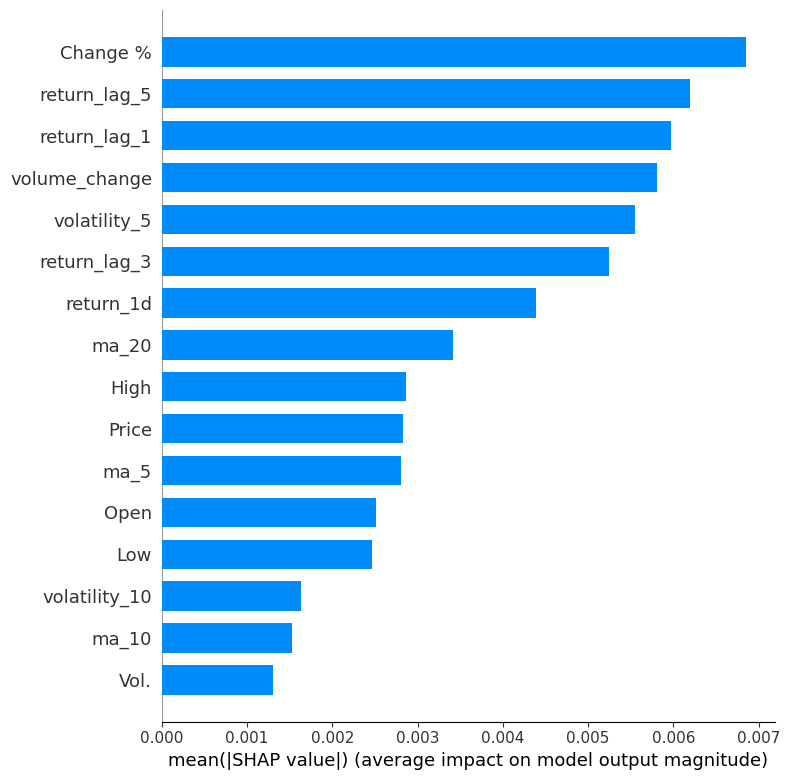

In [28]:
# Global feature importance summary
shap.summary_plot(
    shap_values_pos,
    X_test_shap,
    plot_type="bar",
    show=True
)

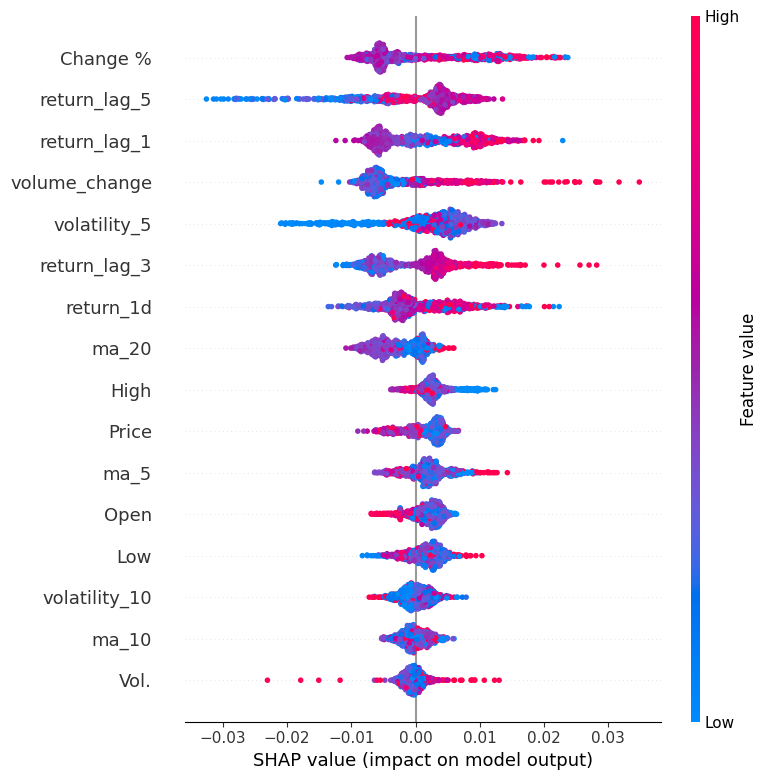

In [29]:
# Distribution-aware global explanation
shap.summary_plot(
    shap_values_pos,
    X_test_shap,
    show=True
)

In [30]:
# Select a high-confidence misclassified sample if available
if "pred_confidence" in misclassified_df.columns and len(misclassified_df) > 0:
    idx_error = (
        misclassified_df.sort_values("pred_confidence", ascending=False)
        .index[0]
    )
else:
    idx_error = misclassified_df.index[0]

# Select a correctly classified sample
idx_correct = (
    error_df[~error_df["is_misclassified"]]
    .sample(1, random_state=42)
    .index[0]
)

idx_error, idx_correct

(np.int64(851), np.int64(922))

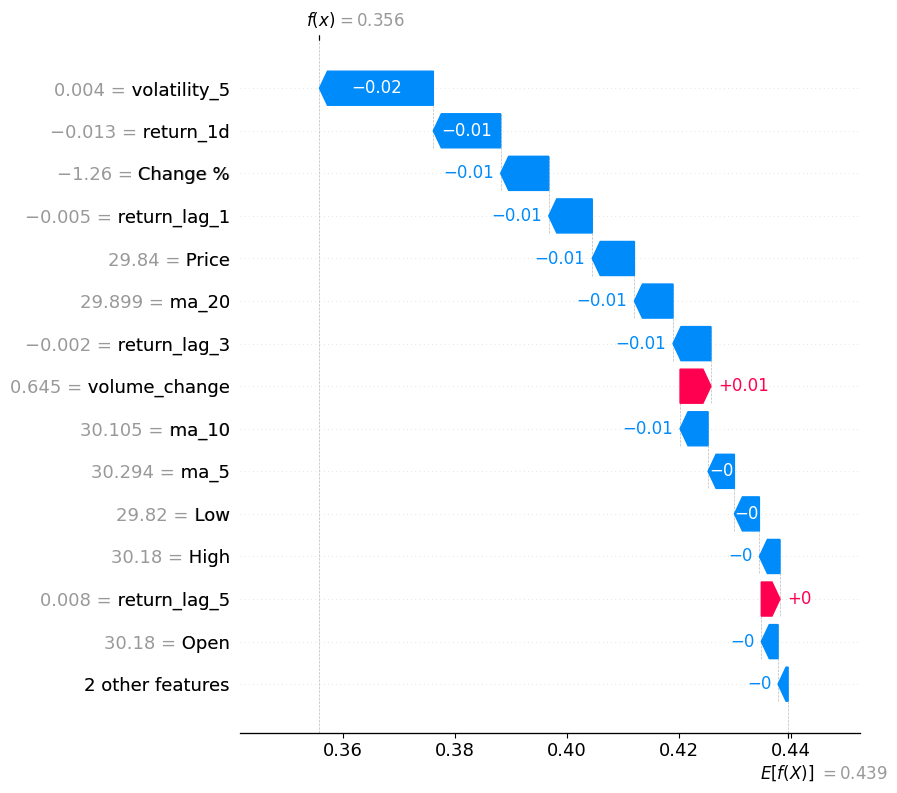

In [33]:
pos_error = X_test_shap.index.get_loc(idx_error)

# Pick the expected value for the selected class (align with shap_values_pos)
if isinstance(explainer.expected_value, (list, np.ndarray)):
    base_value = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
else:
    base_value = explainer.expected_value

exp_error = shap.Explanation(
    values=shap_values_pos[pos_error, :],
    base_values=base_value,
    data=X_test_shap.iloc[pos_error, :].values,
    feature_names=feature_cols
)

shap.plots.waterfall(exp_error, max_display=15)


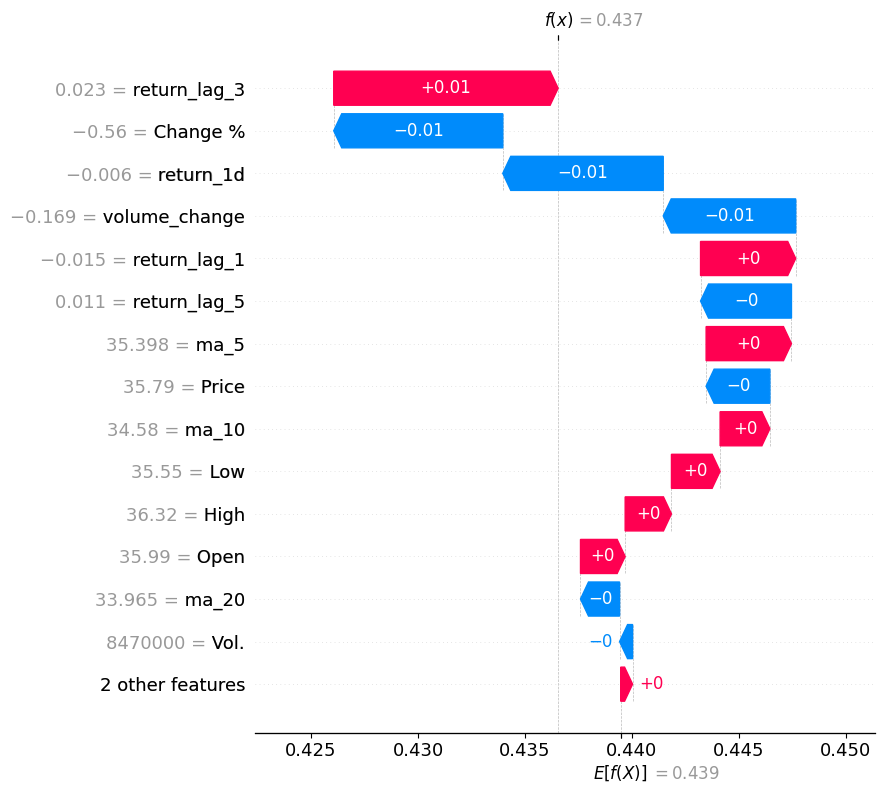

In [35]:
# Local explanation for a single correctly classified sample (matplotlib-friendly)

pos_correct = X_test_shap.index.get_loc(idx_correct)

if isinstance(explainer.expected_value, (list, np.ndarray)):
    base_value = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
else:
    base_value = explainer.expected_value

exp_correct = shap.Explanation(
    values=shap_values_pos[pos_correct, :],
    base_values=base_value,
    data=X_test_shap.iloc[pos_correct, :].values,
    feature_names=feature_cols
)

shap.plots.waterfall(exp_correct, max_display=15)


In [36]:
def top_shap_features_by_pos(pos, top_n=10):
    vals = pd.Series(
        np.abs(shap_values_pos[pos, :]),
        index=feature_cols
    ).sort_values(ascending=False)
    return vals.head(top_n)

top_error_features = top_shap_features_by_pos(pos_error, top_n=10)
top_correct_features = top_shap_features_by_pos(pos_correct, top_n=10)

top_error_features, top_correct_features

(volatility_5     0.020329
 return_1d        0.012017
 Change %         0.008584
 return_lag_1     0.007766
 Price            0.007531
 ma_20            0.006883
 return_lag_3     0.006774
 volume_change    0.005514
 ma_10            0.005001
 ma_5             0.004703
 dtype: float64,
 return_lag_3     0.010492
 Change %         0.007904
 return_1d        0.007503
 volume_change    0.006195
 return_lag_1     0.004450
 return_lag_5     0.004251
 ma_5             0.003990
 Price            0.002981
 ma_10            0.002327
 Low              0.002275
 dtype: float64)

In [37]:
# Save SHAP values for reproducibility
shap_df = pd.DataFrame(
    shap_values_pos,
    columns=feature_cols,
    index=X_test_shap.index
)

shap_output_path = "../data/processed/shap_values_test_positive_class.csv"
shap_df.to_csv(shap_output_path, index=True)

print(f"Saved SHAP values to: {shap_output_path}")

Saved SHAP values to: ../data/processed/shap_values_test_positive_class.csv
